# 프로젝트 : This is your playground! Leaderboard를 정복해 주세요!
---

In [554]:
# import xgboost
# import lightgbm
# import missingno
# import sklearn

# print(xgboost.__version__)
# print(lightgbm.__version__)
# print(missingno.__version__)
# print(sklearn.__version__)

## (1) 데이터 불러오기

In [555]:
import os
project_path = os.getenv('HOME') + '/Desktop/house_prices'
training_path = project_path + '/train.csv'
test_path = project_path + '/test.csv'

In [556]:
import pandas as pd
train = pd.read_csv(training_path)
test =  pd.read_csv(test_path)
print('train: ',train.shape)
print('test: ',test.shape)

print(set(train.columns)- set(test.columns))

train:  (15035, 21)
test:  (6468, 20)
{'price'}


## (2) EDA

In [557]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

### 2.1. 결측값 확인

In [558]:
train.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

## 2.2. 중복데이터 확인

In [559]:
train.duplicated().sum()

0

## 2.3. features 확인

### 2.3.1. features 정의
---
**Data fields**

- `INT`
    - ID : 집을 구분하는 번호 ⚠️
    - bedrooms : 침실의 수 
    - sqft_living : 주거 공간의 평방 피트(면적)
    - sqft_lot : 부지의 평방 피트(면적)
    - waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
    - view : 집이 얼마나 좋아 보이는지의 정도
    - condition : 집의 전반적인 상태
    - grade : King County grading 시스템 기준으로 매긴 집의 등급
    - sqft_above : 지하실을 제외한 평방 피트(면적)
    - sqft_basement : 지하실의 평방 피트(면적)
    - yr_built : 지어진 년도 #flag : date?
    - yr_renovated : 집을 재건축한 년도 
    - zipcode : 우편번호 
    - sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
    - sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)


- `FLOAT`
    - bathrooms : 화장실의 수 ⚠️
    - floors : 집의 층 수 ⚠️
    - lat : 위도 
    - long : 경도 
    

- `OBJECT`
    - date : 집을 구매한 날짜 ⚠️


- `TARGET`
    - price : 집의 가격(Target variable)
    
`⚠️ : 주의깊게 살펴봐야할 feature`

###  2.3.2. dtypes?

In [560]:
train.dtypes.value_counts()

int64      15
float64     5
object      1
dtype: int64

In [561]:
col_int = [train.dtypes.index[i] for i in range(len(train.dtypes)) if train.dtypes[i] == 'int64']
col_float = [train.dtypes.index[i] for i in range(len(train.dtypes)) if train.dtypes[i] == 'float64' and train.dtypes.index[i] != 'price']
col_object = [train.dtypes.index[i] for i in range(len(train.dtypes)) if train.dtypes[i] == 'object']
target = 'price'

print('col_int : ', col_int)
print('col_float : ', col_float)
print('col_object : ', col_object)

col_int :  ['id', 'bedrooms', 'sqft_living', 'sqft_lot', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'sqft_living15', 'sqft_lot15']
col_float :  ['bathrooms', 'floors', 'lat', 'long']
col_object :  ['date']


### 2.4. features correlations

High Corrlations :

- sqft_living & sqft_above (0.88)
- sqft_living & grade (0.76)
- sqft_living & sqft_living15 (0.76)
- sqft_living & bathrooms (0.75)


\* *Grade(King County Grading System)*
- 건축상태, 건축비용, 건축 디자인, 건축옵션 들을 고려한 체첨 시스템 </br>[source] https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r

In [562]:
train.corr().style.background_gradient(cmap='YlGn')

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,0.020899,0.010520,0.104030,0.041725,-0.034077,0.182848,-0.011775,-0.024360,-0.101618,0.078622,0.073086,-0.050634,0.202477,-0.029810,-0.005761,0.002588,0.014757,0.029248,-0.032269
price,0.020899,1.000000,0.323672,0.525479,0.702899,0.096793,0.262588,0.265738,0.400806,0.039740,0.667211,0.608577,0.322218,0.047290,0.140808,-0.051498,0.301604,0.023547,0.586419,0.086384
bedrooms,0.010520,0.323672,1.000000,0.530548,0.596974,0.033475,0.189532,-0.004819,0.085703,0.034885,0.375286,0.494867,0.315183,0.158799,0.022729,-0.162081,-0.011190,0.135802,0.407394,0.027242
bathrooms,0.104030,0.525479,0.530548,1.000000,0.755853,0.089308,0.508649,0.075452,0.187488,-0.125907,0.666278,0.688255,0.282642,0.503964,0.065423,-0.207500,0.018110,0.227669,0.573541,0.088120
sqft_living,0.041725,0.702899,0.596974,0.755853,1.000000,0.176500,0.363193,0.108137,0.282821,-0.054213,0.762543,0.878736,0.434017,0.315927,0.064893,-0.200745,0.051609,0.245429,0.760271,0.184176
sqft_lot,-0.034077,0.096793,0.033475,0.089308,0.176500,1.000000,0.001535,0.025584,0.080441,-0.002099,0.119906,0.186242,0.017818,0.058686,-0.001451,-0.127709,-0.082234,0.227451,0.147562,0.728458
floors,0.182848,0.262588,0.189532,0.508649,0.363193,0.001535,1.000000,0.031159,0.034511,-0.261016,0.462598,0.529476,-0.239350,0.490436,0.009752,-0.059107,0.049004,0.126983,0.287125,-0.010287
waterfront,-0.011775,0.265738,-0.004819,0.075452,0.108137,0.025584,0.031159,1.000000,0.389669,0.011613,0.088061,0.081968,0.071576,-0.026523,0.104168,0.028632,-0.014772,-0.037922,0.091810,0.028255
view,-0.024360,0.400806,0.085703,0.187488,0.282821,0.080441,0.034511,0.389669,1.000000,0.045255,0.247924,0.172693,0.265880,-0.061670,0.107605,0.089247,0.005285,-0.073151,0.278267,0.076501
condition,-0.101618,0.039740,0.034885,-0.125907,-0.054213,-0.002099,-0.261016,0.011613,0.045255,1.000000,-0.143599,-0.152856,0.175064,-0.366590,-0.062342,0.001106,-0.015974,-0.110742,-0.091407,-0.003873


### 2.5. target column

In [563]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

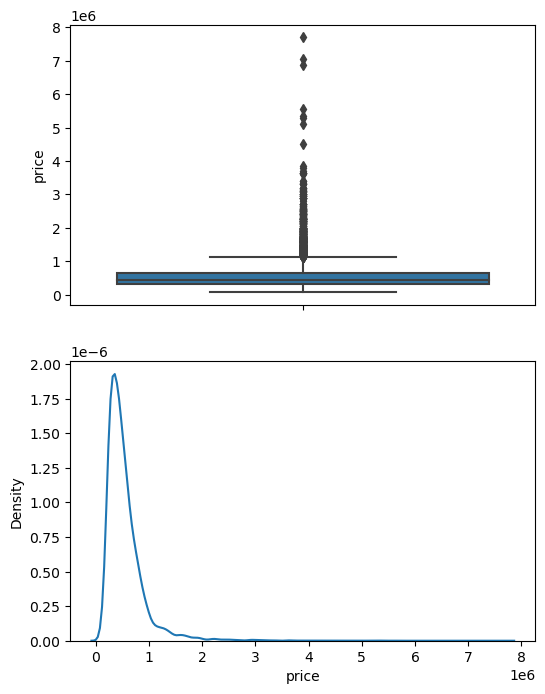

In [564]:
price = train[target]
fig = plt.figure(figsize = (6,8))
ax = fig.add_subplot(2,1,1)
sns.boxplot(y=price)

ax1 = fig.add_subplot(2,1,2)
sns.kdeplot(x=price)

plt.show()

In [565]:
# remove outliers
train[train['price'] < 6000000]
train = train[train['price'] < 6000000]

### 2.6. int64 features
---

In [566]:
def graph_hist_scatter(dataset, feature, target):
    fig = plt.figure(figsize = (12,4))

    ax = fig.add_subplot(1,2,1)
    sns.histplot(data=dataset, x=feature)
    plt.title(f'{feature} hist')
    plt.xlabel('')

    ax = fig.add_subplot(1,2,2)
    sns.regplot(data=dataset, x=feature, y=target)
    plt.title(f'{feature} vs {target}')
    plt.xlabel('')
    plt.show()

In [567]:
def graph_count_scatter(dataset, feature, target):
    fig = plt.figure(figsize = (12,4))

    ax = fig.add_subplot(1,2,1)
    sns.countplot(data=dataset, x=feature)
    plt.title(f'{feature} count')
    plt.xlabel('')

    ax = fig.add_subplot(1,2,2)
    sns.regplot(data=dataset, x=feature, y=target)
    plt.title(f'{feature} vs {target}')
    plt.xlabel('')
    plt.show()

In [568]:
def graph_count_box(dataset, feature, target):
    fig = plt.figure(figsize = (12,4))

    ax = fig.add_subplot(1,2,1)
    sns.countplot(data=dataset, x=feature)
    plt.title(f'{feature} count')
    plt.xlabel('')

    ax = fig.add_subplot(1,2,2)
    sns.boxplot(data=dataset, x=feature, y=target)
    plt.title(f'{feature} vs {target}')
    plt.xlabel('')
    plt.show()

In [569]:
def graph_hist_box(dataset, feature, target):
    fig = plt.figure(figsize = (12,4))

    ax = fig.add_subplot(1,2,1)
    sns.histplot(data=dataset, x=feature)
    plt.title(f'{feature} hist')

    ax = fig.add_subplot(1,2,2)
    sns.boxplot(data=dataset, x=feature, y=target)
    plt.title(f'{feature} vs {target}')
    plt.show()

### 2.6.1. ID

ID는 각 데이터의 고유번호로 큰 의미가 없습니다. 모델 분석시에는 제외하도록 하겠습니다.

### 2.6.2. Bedrooms

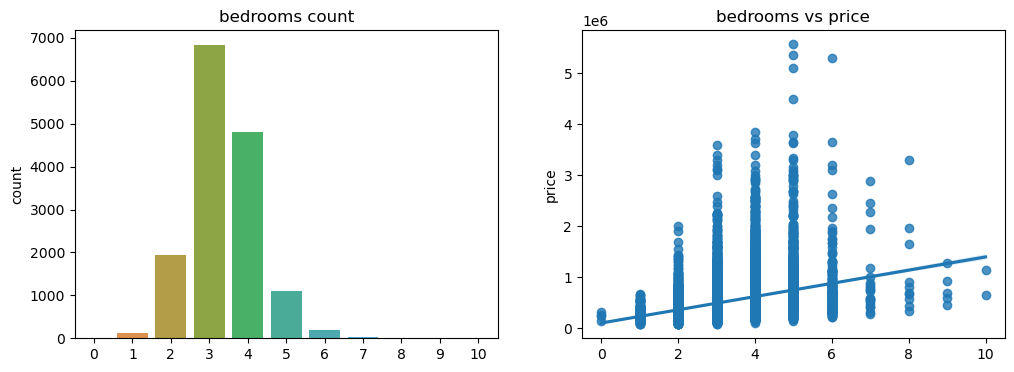

In [570]:
graph_count_scatter(train, 'bedrooms', 'price')

### 2.6.3. sqft_living vs sqft_above vs sqft_basement

In [571]:
# sqft_living - sqft_above = sqft_basement
train[['sqft_living15','sqft_living','sqft_above','sqft_basement','sqft_lot','sqft_lot15']]

,sqft_living15,sqft_living,sqft_above,sqft_basement,sqft_lot,sqft_lot15
0,1340,1180,1180,0,5650,5650
1,2720,770,770,0,10000,8062
2,1800,1680,1680,0,8080,7503
3,2238,1715,1715,0,6819,6819
4,1650,1060,1060,0,9711,9711
...,...,...,...,...,...,...
15030,2520,2520,2520,0,6023,6023
15031,2050,3510,2600,910,7200,6200
15032,1530,1530,1530,0,1131,1509
15033,1830,2310,2310,0,5813,7200


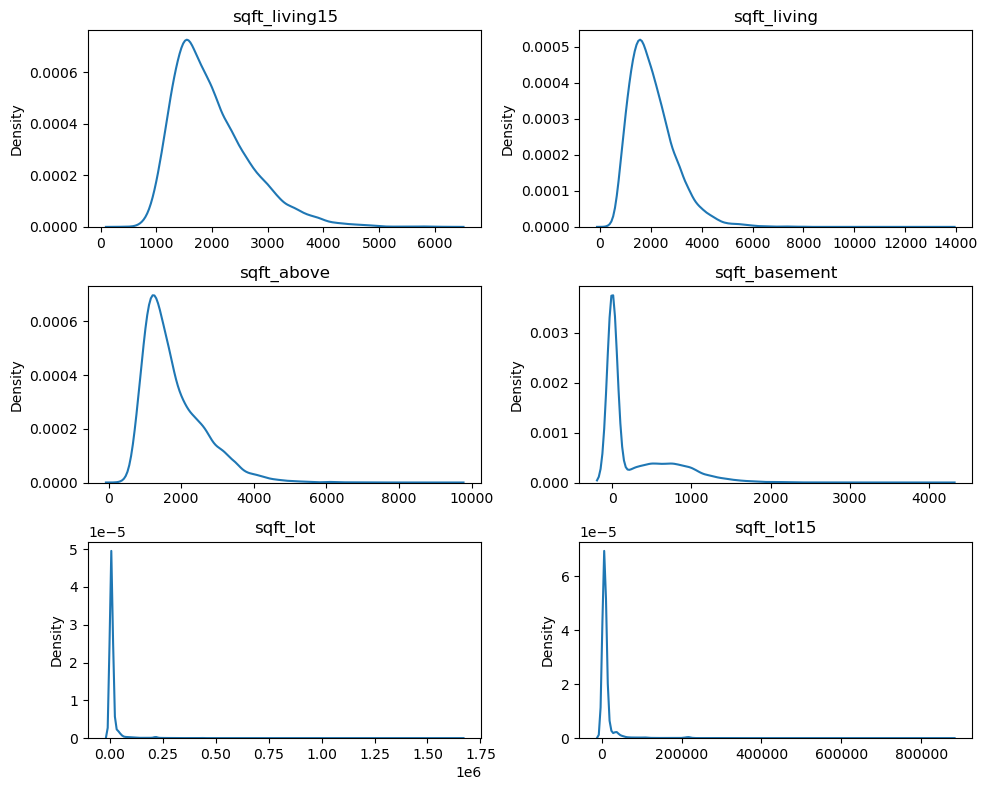

In [572]:
sqft =['sqft_living15','sqft_living','sqft_above','sqft_basement','sqft_lot','sqft_lot15']

fig = plt.figure(figsize = (10,8))
for i, col in enumerate(sqft) :
    ax = fig.add_subplot(3,2,i+1)
    sns.kdeplot(data=train,x=col)
    plt.xlabel('')
    plt.title(col)

plt.tight_layout()
plt.show()

In [573]:
from scipy.stats import skew

모든 feature들의 왜도 값이 1 이상입니다. 

np.log1p 를 이용해서 정규화 작업이 필요합니다.

In [574]:
for i in sqft :
    print(f'Skewness of {i} : {skew(train[i])}')

Skewness of sqft_living15 : 1.1245791992721614
Skewness of sqft_living : 1.3662992910648408
Skewness of sqft_above : 1.3586428334669851
Skewness of sqft_basement : 1.5383473836638848
Skewness of sqft_lot : 13.348714594309834
Skewness of sqft_lot15 : 10.027990160682432


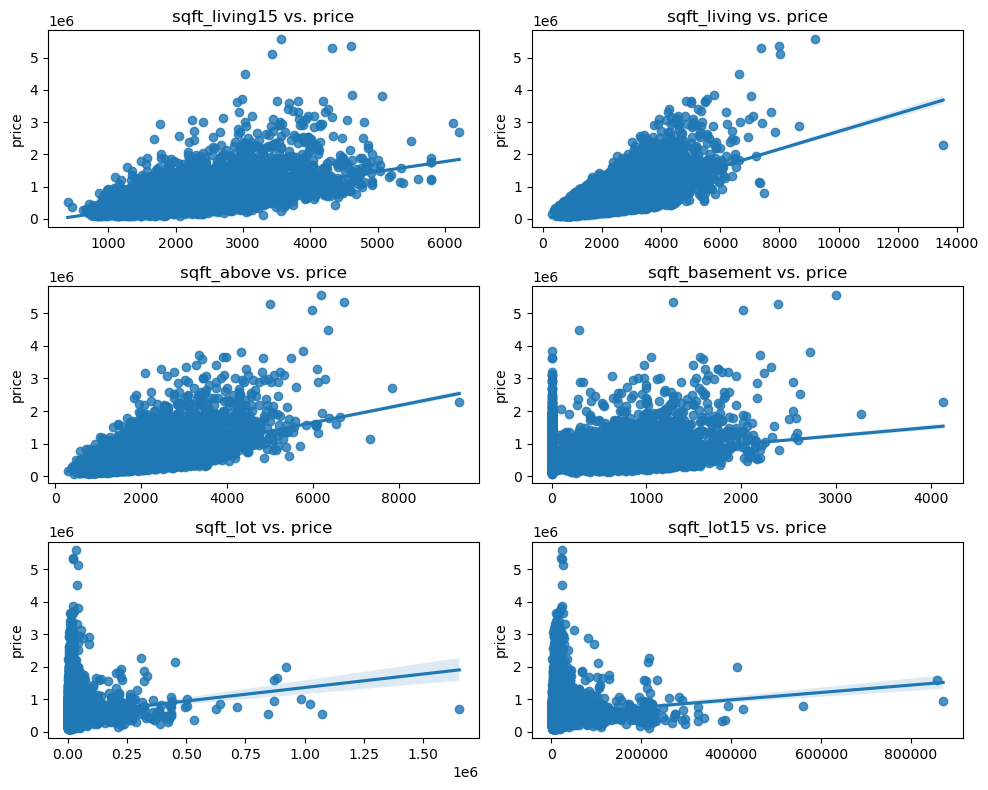

In [575]:
fig = plt.figure(figsize = (10,8))
for i, col in enumerate(sqft) :
    ax = fig.add_subplot(3,2,i+1)
    sns.regplot(data=train,x=col, y='price')
    plt.xlabel('')
    plt.title(f"{col} vs. price")

plt.tight_layout()
plt.show()

In [576]:
#sqft_living and sqft_above remove from model

train[sqft].corr().style.background_gradient(cmap='YlGn')

,sqft_living15,sqft_living,sqft_above,sqft_basement,sqft_lot,sqft_lot15
sqft_living15,1.000000,0.761994,0.738230,0.196434,0.147466,0.183465
sqft_living,0.761994,1.000000,0.877210,0.430044,0.177344,0.185046
sqft_above,0.738230,0.877210,1.000000,-0.056206,0.186808,0.194715
sqft_basement,0.196434,0.430044,-0.056206,1.000000,0.017521,0.018668
sqft_lot,0.147466,0.177344,0.186808,0.017521,1.000000,0.728463
sqft_lot15,0.183465,0.185046,0.194715,0.018668,0.728463,1.000000


### 2.6.4. waterfront

주변에 물이 많은 것 같습니다. 

가격 예측하는데는 이 도시에서는 큰 도움을 받기는 어렵겠네요.

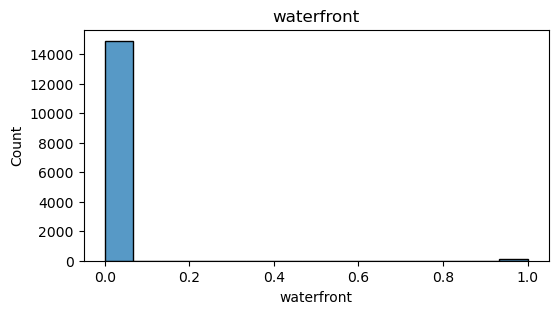

In [577]:
fig = plt.figure(figsize = (6,3))
sns.histplot(train['waterfront'])
plt.title('waterfront')
plt.show()

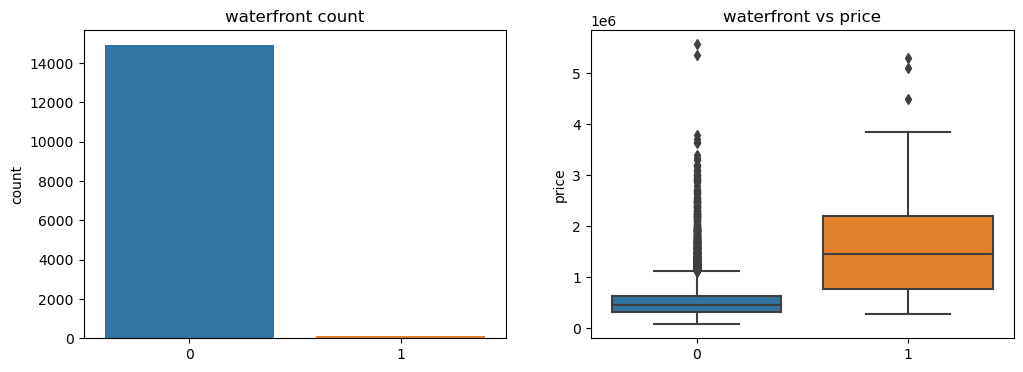

In [578]:
graph_count_box(train, 'waterfront', 'price')

### 2.6.5. view

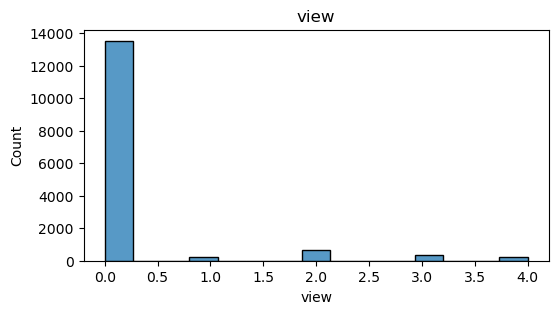

In [579]:
fig = plt.figure(figsize = (6,3))
sns.histplot(train['view'])
plt.title('view')
plt.show()

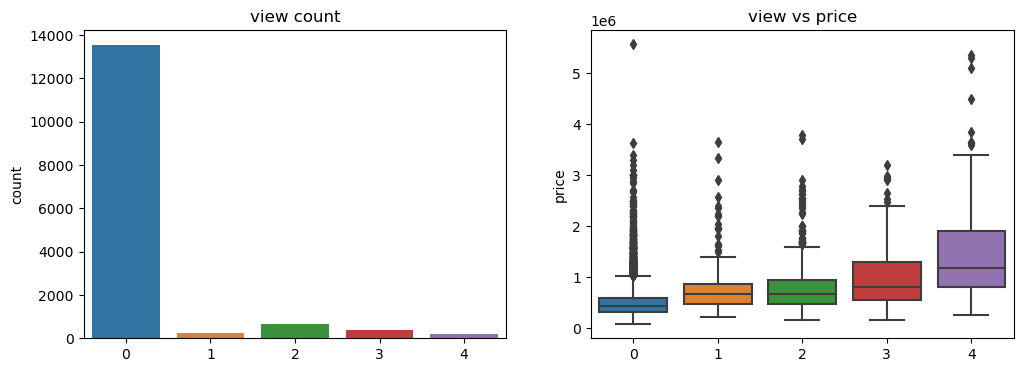

In [580]:
graph_count_box(train, 'view', 'price')

### 2.6.6. condition

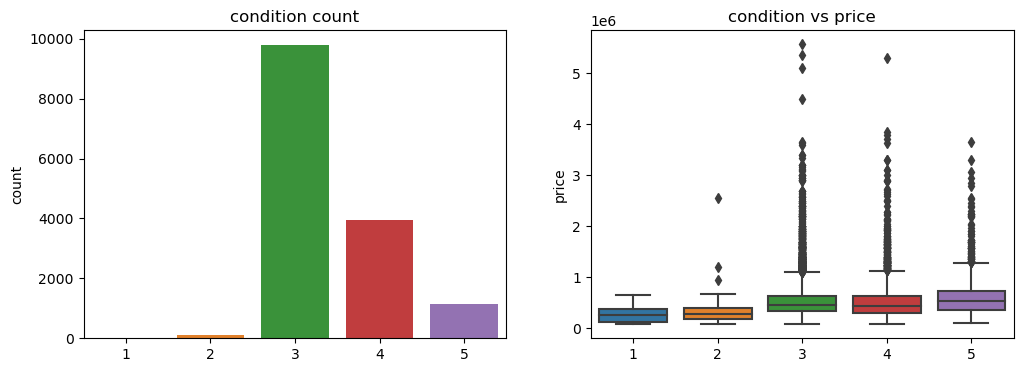

In [581]:
graph_count_box(train, 'condition', 'price')

### 2.6.7. grade

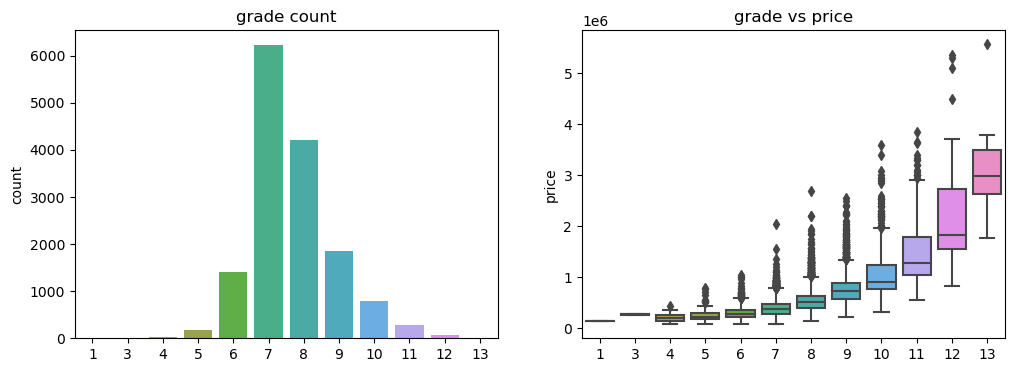

In [582]:
graph_count_box(train, 'grade', 'price')

### 2.6.8. yr_built & yr_renovated

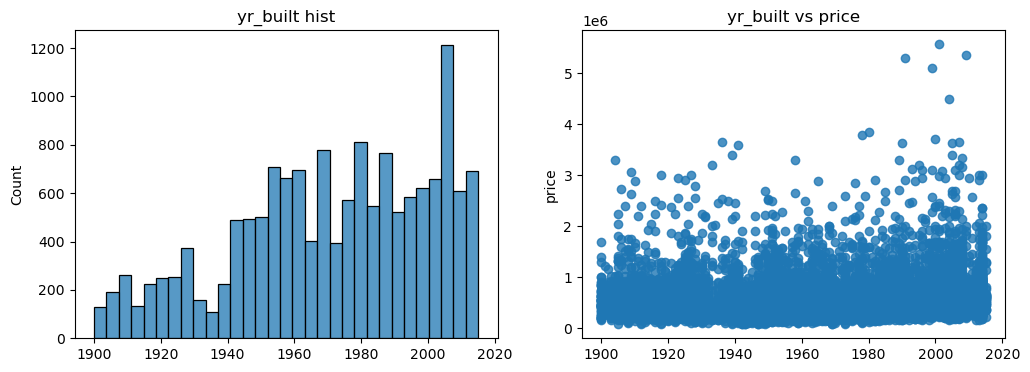

In [583]:
graph_hist_scatter(train,'yr_built','price')

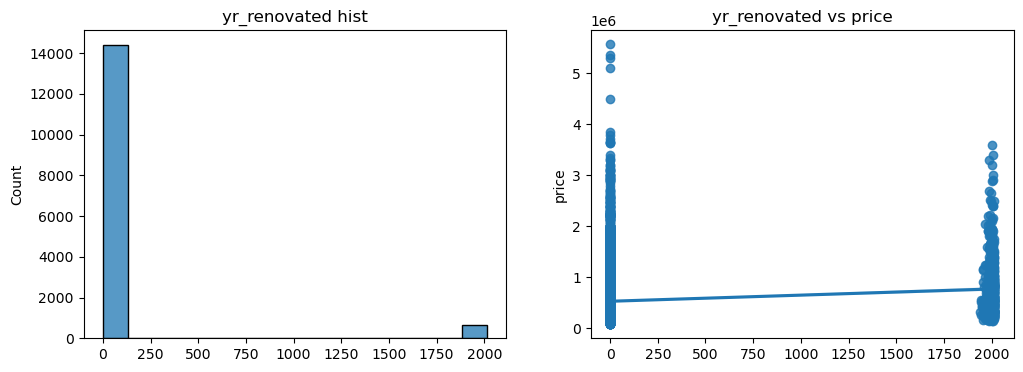

In [584]:
graph_hist_scatter(train,'yr_renovated','price')

### 2.6.9. zipcode

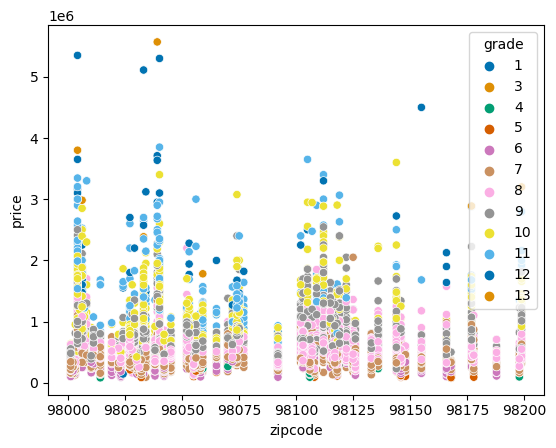

In [585]:
sns.scatterplot(data=train, y='price', x='zipcode', hue= 'grade', palette = 'colorblind')
plt.show()

### 2.7. float features

---

### 2.7.1 bathrooms

In [586]:
train['bathrooms'].value_counts().sort_index()

0.00       4
0.50       3
0.75      45
1.00    2675
1.25       5
1.50    1009
1.75    2112
2.00    1357
2.25    1433
2.50    3748
2.75     843
3.00     493
3.25     410
3.50     510
3.75     108
4.00     100
4.25      57
4.50      63
4.75      16
5.00      14
5.25      11
5.50       7
5.75       3
6.00       2
6.25       1
6.75       1
7.50       1
8.00       1
Name: bathrooms, dtype: int64

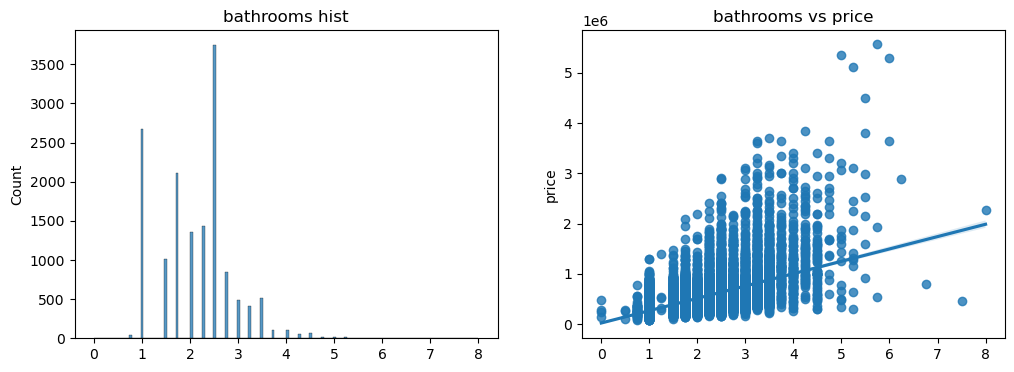

In [587]:
graph_hist_scatter(train, 'bathrooms','price')

### 2.7.2. floor

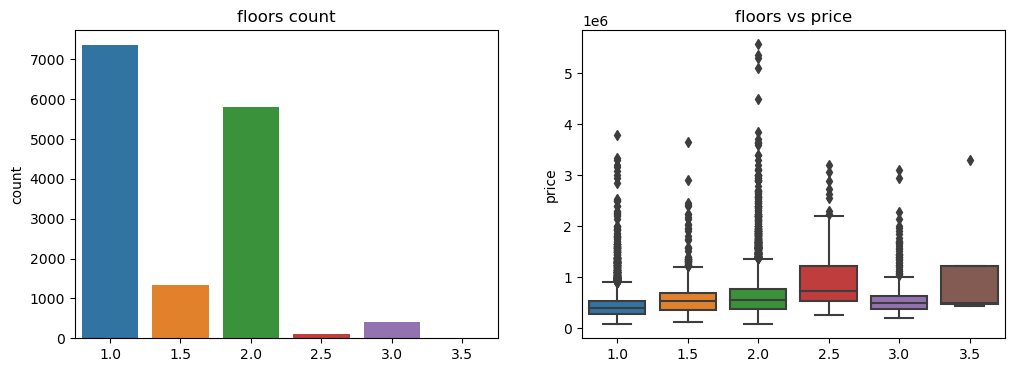

In [588]:
graph_count_box(train, 'floors','price')

### 2.7.3. latitude and longitude

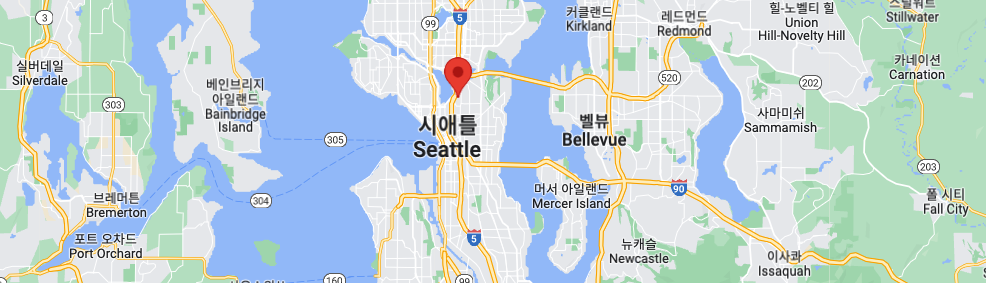

위도 경고 좌표를 구글 맵 찍어봤을 때 미국 워싱턴 주를 가르키는 것 같습니다. 

주요 도시로 Seattle과 Bellavue가 보입니다.

주요 도시와의 거리도 가격을 설명해주는 feature로 사용하면 좋을 것 같습니다. 

거리를 측정해주는 방법으로는 harvesine 함수를 사용하겠습니다. 

식은 다음 이미지와 같습니다. 

이를 이용해서 주요 도시 Seattle과 Bellavue와의 거리를 측정해서 새로운 feature를 만들어보겠습니다. 

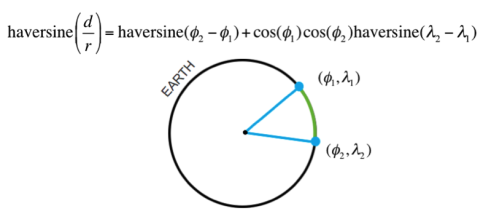

https://medium.com/@krexvelasco/transforming-categorical-information-into-usable-measures-in-a-machine-learning-model-e2910bbb3fc7

In [589]:
# !pip install haversine

In [590]:
from haversine import haversine, Unit

In [591]:
seattle = [46.6092, -122.3363]
bellevue = [47.61555, -122.20392]

In [592]:
haversine(seattle, bellevue,unit=Unit.MILES)

69.8102115661099

In [593]:
#train
train['coordinates'] = list(zip(train['lat'],train['long']))
train['seattle_dist'] = train['coordinates'].apply(lambda x: haversine(x,seattle,unit =Unit.MILES))
train['bellevue_dist'] = train['coordinates'].apply(lambda x: haversine(x,bellevue,unit =Unit.MILES))

#test
test['coordinates'] = list(zip(test['lat'],test['long']))
test['seattle_dist'] = test['coordinates'].apply(lambda x: haversine(x,seattle,unit =Unit.MILES))
test['bellevue_dist'] = test['coordinates'].apply(lambda x: haversine(x,bellevue,unit =Unit.MILES))

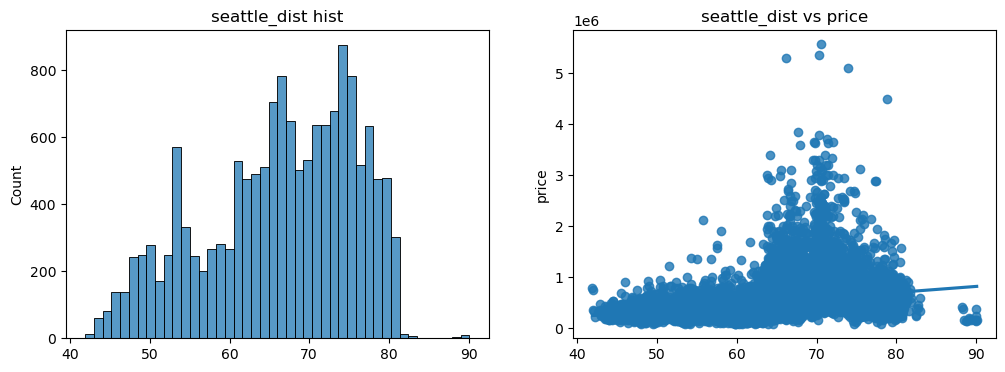

In [594]:
graph_hist_scatter(train, 'seattle_dist','price')

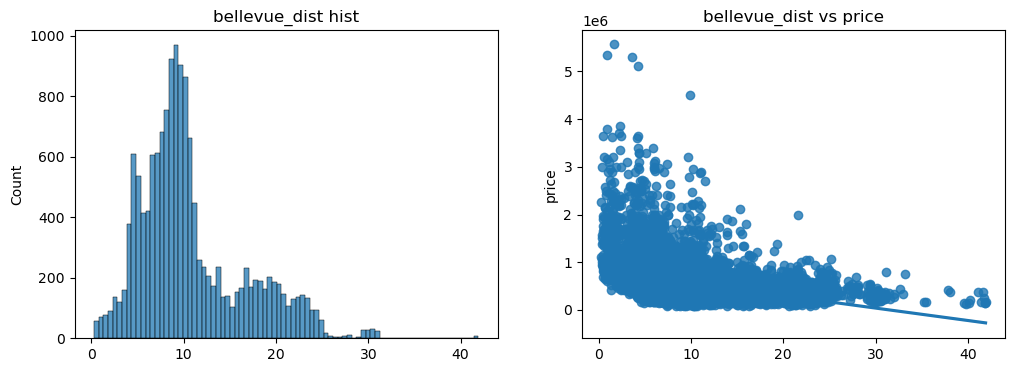

In [595]:
graph_hist_scatter(train, 'bellevue_dist','price')

In [596]:
train[['price','seattle_dist','bellevue_dist','lat','long']].corr().style.background_gradient(cmap='YlGn')

,price,seattle_dist,bellevue_dist,lat,long
price,1.000000,0.310942,-0.417332,0.309819,0.025594
seattle_dist,0.310942,1.000000,-0.665851,0.994206,-0.039761
bellevue_dist,-0.417332,-0.665851,1.000000,-0.703235,0.245347
lat,0.309819,0.994206,-0.703235,1.000000,-0.133435
long,0.025594,-0.039761,0.245347,-0.133435,1.000000


### 2.7. date feature

date feature는 현재 object 자료형입니다. 회귀 모델에 사용하기 위해서 숫자로 바꿔주겠습니다. 

In [597]:
train['date'].describe()

count               15032
unique                365
top       20140623T000000
freq                  101
Name: date, dtype: object

In [598]:
#train
train['date'] = train['date'].apply(lambda x : x[:6]).astype(int)

#test
test['date'] = test['date'].apply(lambda x : x[:6]).astype(int)

In [599]:
train['date'].describe()

count     15032.000000
mean     201438.552022
std          44.254400
min      201405.000000
25%      201407.000000
50%      201410.000000
75%      201502.000000
max      201505.000000
Name: date, dtype: float64

## (3) Feature Engineering and Feature Selection and Feature Scaling

### 3.1. Feature Engineering

In [600]:
#train
train['floor_area_ratio'] = train['sqft_living'] / train['sqft_lot']
train['rooms'] = train['bedrooms'] + train['bathrooms']
train['grade_condition'] = train['grade'] * train['condition']
train['sqft_total_size'] = train['sqft_above'] + train['sqft_basement']

#test
test['floor_area_ratio'] = test['sqft_living'] / test['sqft_lot']
test['rooms'] = test['bedrooms'] + test['bathrooms']
test['grade_condition'] = test['grade'] * test['condition']
test['sqft_total_size'] = test['sqft_above'] + test['sqft_basement']

### 3.2. Feature Selection

In [601]:
set(train.columns) - set(test.columns)

{'price'}

In [602]:
removing_feature = ['id', 'coordinates', 'price'] #'lat','long','sqft_living15','sqft_above',

In [603]:
selected_feature = list(set(train.columns) - set(removing_feature))

In [604]:
import numpy as np

for i in sqft :
    train[i] = train[i].apply(lambda x : np.log1p(x))
    test[i] = test[i].apply(lambda x : np.log1p(x))

In [605]:
X_train = train[selected_feature].values
y_train = train['price'].apply(lambda x : np.log1p(x))
X_test = test[selected_feature].values

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(15032, 25)
(15032,)
(6468, 25)


### 3.3. Feature Scaling

In [606]:
from sklearn.preprocessing import MinMaxScaler

In [607]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

## (4) Train Validation Split

In [608]:
from sklearn.model_selection import train_test_split

In [609]:
X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, test_size=0.2, random_state=2022)

## (5) Model Baseline

In [610]:
# Import Model
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge

# Metric
from sklearn.metrics import mean_squared_error

In [611]:
model = LGBMRegressor(random_state=2022)

def get_score_prediction(model, x,y, test, true) :
    model.fit(x,y)
    pred = model.predict(test)
    print('RMSE is :', mean_squared_error(np.expm1(true), np.expm1(pred)) ** 0.5)
    return np.expm1(pred)

get_score_prediction(model, X_t, y_t, X_v, y_v)

RMSE is : 110151.2619336184


array([838512.09341096, 484874.96086698, 176540.25973239, ...,
       653571.39561521, 517708.9751178 , 216224.77521434])

In [612]:
model2 = XGBRegressor(random_state=2022)
get_score_prediction(model2, X_t, y_t, X_v, y_v)

RMSE is : 117113.82912733541


array([791846.25, 500380.94, 190429.12, ..., 626204.6 , 508048.56,
       227487.1 ], dtype=float32)

In [613]:
model3 = RandomForestRegressor(random_state=2022)
get_score_prediction(model3, X_t, y_t, X_v, y_v)

RMSE is : 132413.77820715785


array([911174.89478509, 479021.76231201, 173374.90513104, ...,
       636729.76398133, 496106.8636939 , 232592.93424766])

## (6) Model Tuning : Cross Validation & Hyper-Parameter Tuning

### 6.1. Cross Validation

In [286]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [287]:
xgb = XGBRegressor(random_state=2022)
lgb = LGBMRegressor(random_state=2022)
rfr = RandomForestRegressor(random_state=2022)

models  = [xgb,ridge,lgb,rdf]

In [291]:
for model in models:
    result = cross_val_score(model, X_t, y_t, cv=5, n_jobs = 5)
    print(f'{model.__class__.__name__} : {result}')

XGBRegressor : [0.90900436 0.8992432  0.89333893 0.90512081 0.88935377]
Ridge : [0.82288676 0.80373817 0.80625524 0.80653862 0.80608116]
LGBMRegressor : [0.91071952 0.89917946 0.89885484 0.90945492 0.89545862]
RandomForestRegressor : [0.89701789 0.8820894  0.88629376 0.8955091  0.8841599 ]


### 6.2. Hyper Parameter Tuning

In [298]:
from sklearn.model_selection import GridSearchCV

In [302]:
def myGrid(model, param,x, y):
    mygrid = GridSearchCV(model, param_grid = param, scoring = 'neg_mean_squared_error', n_jobs=3, verbose=1)
    mygrid.fit(x,y)
    params= mygrid.cv_results_['params']
    score= mygrid.cv_results_['mean_test_score']
    for i in range(len(params)):
        params[i]['score'] = score[i]
        
    return pd.DataFrame(params).sort_values(by='score', ascending=False)

### 6.2.1. LGBMregressor 

In [321]:
param_grid = {'max_depth' : [-1,15,32], 'n_estimators' : [100,1100,3100], 
              'num_leaves':[43,50,112],'learning_rate': [0.1, 0.015]}

In [306]:
# result = myGrid(lgb,param_grid,X_t,y_t)
result

Fitting 5 folds for each of 72 candidates, totalling 360 fits


,learning_rate,max_depth,n_estimators,num_leaves,score
71,0.015,32,1111,50,-0.025751
44,0.015,-1,1111,50,-0.025751
43,0.015,-1,1111,43,-0.025789
70,0.015,32,1111,43,-0.025789
62,0.015,15,1111,50,-0.025815
...,...,...,...,...,...
54,0.015,15,100,31,-0.054816
36,0.015,-1,100,31,-0.054816
46,0.015,3,100,43,-0.074168
45,0.015,3,100,31,-0.074168


In [616]:
param_grid = {'max_depth' : 32, 'n_estimators' : 8000, 
              'num_leaves': 50,'learning_rate': 0.015}
lgb = LGBMRegressor(random_state=2022, objective= 'regression', **param_grid)
p1 = get_score_prediction(lgb, X_t, y_t,X_v, y_v)

RMSE is : 106529.12431658365


### 6.2.2. XGBRegressor 

In [328]:
# param_grid ={ 'colsample_bytree' : [0.4603,0.8703], 'gamma' : [0.0468,0.0868], 'learning_rate' : [0.1, 0.015],
#              'max_depth' : [6,15,32,75], 'n_estimators' : [1000,3100,8000]}

In [615]:
param_grid ={ 'colsample_bytree' : 0.4603, 'gamma' : 0.0468, 'learning_rate' : 0.015,
             'max_depth' : 75, 'min_child_weight' : 32, 'n_estimators' : 8000,
             'reg_alpha' : 0.4640,'reg_lambda' : 0.8571,'subsample' : 0.8}
xgb = XGBRegressor(random_state=2022, **param_grid)
p2 = get_score_prediction(xgb, X_t, y_t, X_v, y_v)

RMSE is : 106714.26076823196


### 6.2.3. RandomForestRegressor 

In [343]:
param_grid = {'n_estimators' : [50,150,1000,2000]}
rfr = RandomForestRegressor(random_state=2022, n_jobs=-1 )
# result = myGrid(rfr,param_grid,X_t,y_t)
result

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,n_estimators,score
3,2000,-0.030560
2,1000,-0.030595
1,150,-0.030807
0,50,-0.031203


In [618]:
param_grid = {'n_estimators' : 8000}
rfr = LGBMRegressor(random_state=2022, **param_grid)
p3 = get_score_prediction(rfr, X_t, y_t,X_v, y_v)

RMSE is : 107336.60328411407


### 6.3. Blending

In [619]:
def AveragingBlending(models, x, y, sub_x) :
#     for m in models :
#         m.fit(x,y)
    predictions = np.column_stack([
        m.predict(sub_x) for m in models])
    return np.mean(predictions, axis=1)

In [620]:
models = [rfr,lgb, xgb]
y_pred = AveragingBlending(models, X_t, y_t, X_v)

In [621]:
mean_squared_error(np.expm1(y_v),np.expm1(y_pred)) **0.5

104708.12663379611

### 6.4. Ensemble

In [622]:
ensemble_pred = (p1 *0.25 )+ (p2 * 0.7) + (p3 * 0.05)
mean_squared_error(np.expm1(y_v), ensemble_pred) **0.5

105190.45503622381

## (7) Submission

In [623]:
sub_id = test.id
sub_id.shape

(6468,)

In [624]:
def make_submission(model,test) :
    prediction = np.expm1(model.predict(test))
    sub = pd.DataFrame({'id':sub_id, 'price':prediction})
    sub.to_csv(f'submission_{model.__class__.__name__}.csv', index=False)

In [625]:
#lgb
make_submission(lgb, X_test)

In [626]:
#xgb
make_submission(xgb, X_test)

In [627]:
#rfr
make_submission(rfr, X_test)

In [628]:
#averaging blending
av_predictions = np.column_stack([
    m.predict(X_test) for m in models])

sub_av_pred = np.mean(av_predictions, axis=1)
sub = pd.DataFrame({'id':sub_id, 'price':np.expm1(sub_av_pred)})
sub.to_csv(f'submission_Averaging_Blending.csv', index=False)

In [629]:
#ensemble
m1 = np.expm1(lgb.predict(X_test))
m2 = np.expm1(xgb.predict(X_test))
m3 = np.expm1(rfr.predict(X_test))

emsemble_final_pred = (m1 *0.25 )+ (m2 * 0.7) + (m3 * 0.05)
sub = pd.DataFrame({'id':sub_id, 'price':emsemble_final_pred})
sub.to_csv(f'submission_ensemble.csv', index=False)

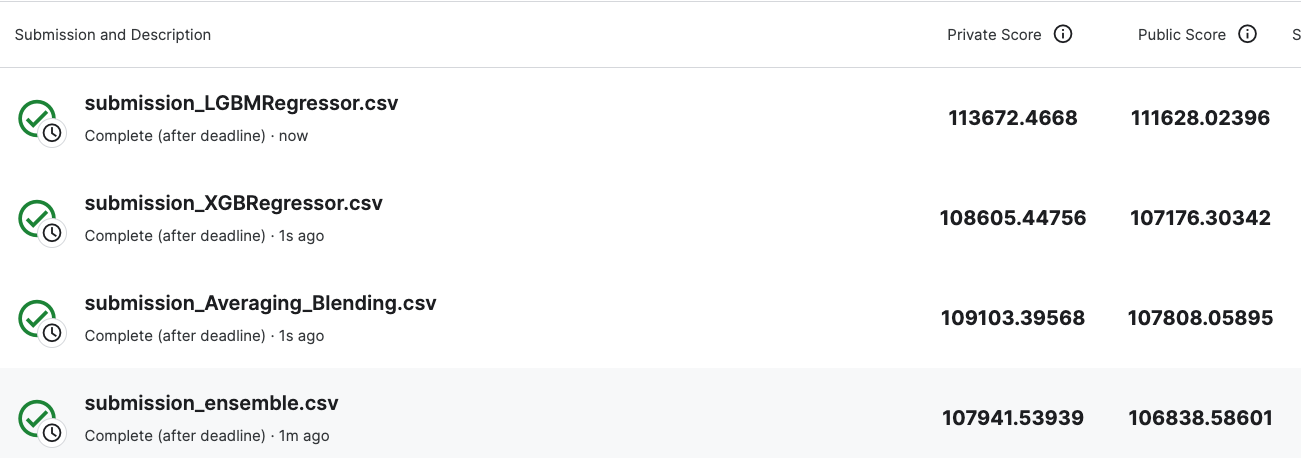